# 2022 EY Data Science Challenge - Training Dataset Summary

Welcome to the 2022 EY Data Science Challenge! In this supplementary notebook, we will be exploring the training dataset that you must use to train your models. The dataset is a subset of the GBIF occurrence dataset which combines data from a wide array of sources, including specimen-related data from natural history museums, observations from citizen science networks, and automated environmental surveys. For our purposes, we are only interested in a narrow subset of the data relating to 9 selected frog species from Australia, Costa Rica, and South Africa. To improve the representation of some frog species, we have expanded the dataset to include some neighbouring countries in Central America and Africa, however your model will be tested on set regions in Australia, Costa Rica, and South Africa. A large source of the Australian data is from a smartphone app called FrogID created by the Australian Museum. This app is free to download and enables citizens to record frog calls which are then classified in the app to tell the user the species. You can check it out [here](https://www.frogid.net.au/).

Now let's spend some time familiarising ourselves with the dataset you will be using to build your models. Firstly, we will explore loading in the data, then we will make some visualisations to better understand it. 

**Note: you must use this instance of the dataset to train your models. Using any other frog occurrence data is prohibited.**


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import contextily as cx
import warnings
import zipfile
import os
warnings.filterwarnings("ignore")

data_path = '../../data/'

The following code will unzip the training data if it hasn't been already.

In [8]:
if not os.path.exists(data_path+'training_data/'):
    os.mkdir(data_path+'/training_data/')
    with zipfile.ZipFile(data_path+'/GBIF_training_data.zip', 'r') as zip_ref:
        zip_ref.extractall(data_path+'/training_data/')

Next, we load in the data. There are 258 fields in the dataset, only a few of which are relevant. We have chosen 9 columns that we think are relevant, but it may be worth sifting through the other fields to find ones that could assist you in the challenge. You can learn more about each of the fields from the [GBIF docs](https://docs.gbif.org/georeferencing-quick-reference-guide/1.0/en/). 

Below we also display the percentage of null values for each of the 9 fields. You may want to look at the documentation to better understand what these null values mean and how best to handle them.

In [11]:
columns = [
    'gbifID','eventDate','country','continent','stateProvince',
    'decimalLatitude','decimalLongitude','species', 'coordinateUncertaintyInMeters'
]

country_names = {
    'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
    'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
    'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
    'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
}

continent_names = {
    'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
    'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
    'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
    'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
}
    
data = (
    pd.read_csv(data_path+'./training_data/occurrence.txt', sep='\t', parse_dates=['eventDate'])
    .assign(
        country =  lambda x: x.countryCode.map(country_names),
        continent =  lambda x: x.countryCode.map(continent_names),
        species = lambda x: x.species.str.title()
    )
    [columns]
)

np.sum(data.isna())/len(data)*100

gbifID                           0.000000
eventDate                        4.522914
country                          0.000000
continent                        0.000000
stateProvince                    0.357086
decimalLatitude                  0.000000
decimalLongitude                 0.000000
species                          0.000000
coordinateUncertaintyInMeters    8.986485
dtype: float64

## Spatial Distribution

Next, we plot the spatial distribution of the occurrences of the dataset.


In [12]:
species_colourmap = {species:colour['color'] for species, colour in zip(data.species.value_counts().index, cycle(plt.rcParams['axes.prop_cycle']))}

def plot_species(fig, ax, frog_data, region_name, colourmap=None):
    # Bar chart
    bar_data = frog_data.species.value_counts()
    barchart = ax[1].bar(bar_data.index.str.replace(' ', '\n'), bar_data)
    # Colour cycle to ensure colors match in both plots
    if colourmap is None:
        colourmap = {species:colour['color'] for species, colour in zip(frog_data.species.value_counts().index, cycle(plt.rcParams['axes.prop_cycle']))}
    
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i in range(len(bar_data)):
        species_name = bar_data.index[i]
        if len(species_name) > 19:
            display_name = species_name.replace(' ', '\n')
        else:
            display_name = species_name
        barchart[i].set_color(colourmap[species_name])
        barchart[i].set_label(f"{display_name}\nCount: {bar_data[i]}")
        filt = frog_data.species == species_name
        # Scatter plot
        ax[0].scatter(
            frog_data[filt].decimalLongitude, 
            frog_data[filt].decimalLatitude, 
            marker='.', 
            color=colourmap[species_name]
        )
    # Add other features
    ax[0].set_title(f"Frog occurrences for {region_name}")
    ax[0].set_xticklabels([])
    ax[0].set_yticklabels([])
    ax[1].set_title(f"Frog species distribution in {region_name}")
    cx.add_basemap(ax[0], crs={'init':'epsg:4326'}, alpha=0.5) # Add basemap
    ax[1].set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax[1].legend()
    
def plot_barchart(bar_data, ax, colourmap=None, bar_params={}):
    barchart = ax.bar(bar_data.index, bar_data, **bar_params)
    if colourmap is None:
        prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
        colourmap = {spec:col['color'] for spec, col in zip(bar_data.index, prop_cycle)}
    for i in range(len(bar_data)):
        var_name = bar_data.index[i]
        barchart[i].set_color(colourmap[var_name])
        barchart[i].set_label(f"{var_name}\nCount: {bar_data[i]}")
    ax.set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax.legend()

Text(0.5, 1.0, 'Frog occurrences by country')

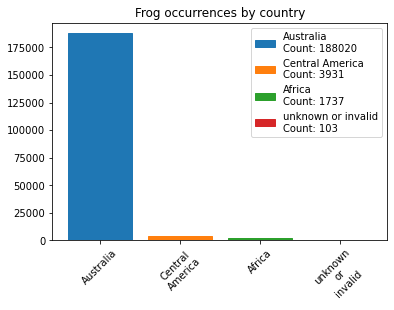

In [13]:
country_bar_data = data.continent.value_counts()
fig, ax = plt.subplots()
plot_barchart(country_bar_data, ax)
ax.set_title('Frog occurrences by country')

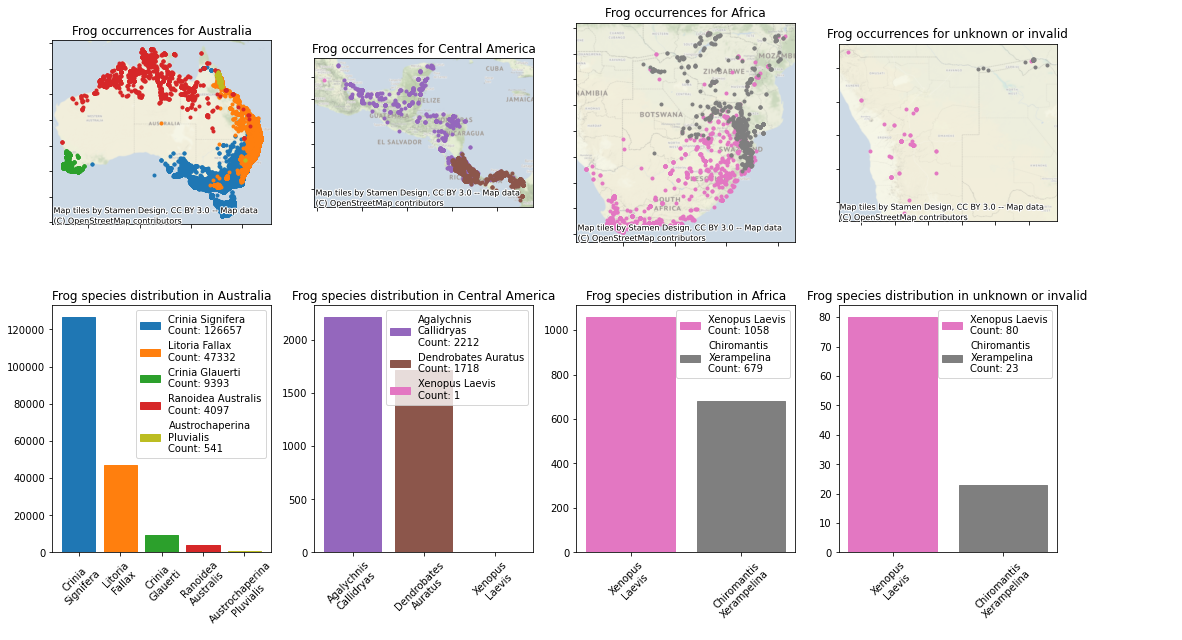

In [16]:
fig, ax = plt.subplots(2, 4, figsize=(18, 10))
for i, cnt in enumerate(data.continent.unique()):
    filt = data.continent == cnt
    plot_species(fig, ax[:, i], data[filt], cnt, colourmap=species_colourmap)
plt.show()

From above, it looks like there is some messiness inherent in the data. For instance, there are some points in Africa that have an unknown country label, and there is one lone occurrence of an African frog species in Mexico. We will remove all of these points and only take instances in Australia, Costa Rica, and South Africa. You are welcome and encouraged to utilise the occurrences in neighbouring countries.

In [14]:
# Remove stray Xenopus Laevis found in Mexico
data = data[~((data.continent == 'Central America') & (data.species == 'Xenopus Laevis'))]
# Remove unknown/invalid continent
data = data[~(data.continent == 'unknown or invalid')]
# Take only Australia, Costa Rica, and South Africa
data = data[data.country.str.contains('Australia|Costa Rica|South Africa')]

To assist in exploring the data, below we have defined an interactive map using the folium package. 

In [15]:
import folium

#create a map
frog_map = folium.Map(prefer_canvas=True)

# Plotting functions
def plotDot(point, folium_map, species_colours):
    folium.CircleMarker(
        location=[point.decimalLatitude, point.decimalLongitude],
        radius=10,
        stroke=False,
        weight=5,
        fill=True,
        fillOpacity=1.0,
        opacity=1.0,
        color=species_colours[point.species]
    ).add_to(folium_map)

# plot 1000 points from each country
(
     data[data.country == 'Australia'].sample(1000, random_state=420).append(
         data[data.country == 'Costa Rica'].sample(1000, random_state=420).append(
             data[data.country == 'South Africa'].sample(1000, random_state=420)
         )
     )
).apply(
    plotDot, axis = 1, args=(frog_map, species_colourmap)
)

#Set the zoom to the maximum possible
frog_map.fit_bounds(frog_map.get_bounds())

#Save the map to an HTML file
frog_map.save('frog_map_training.html')

frog_map

## Temporal Distribution

Another aspect of the dataset that might be worth exploring is the temporal component. When building your models, you should consider whether older observations are relevant to pair with newer satellite data. We plot the occurrences over time below.

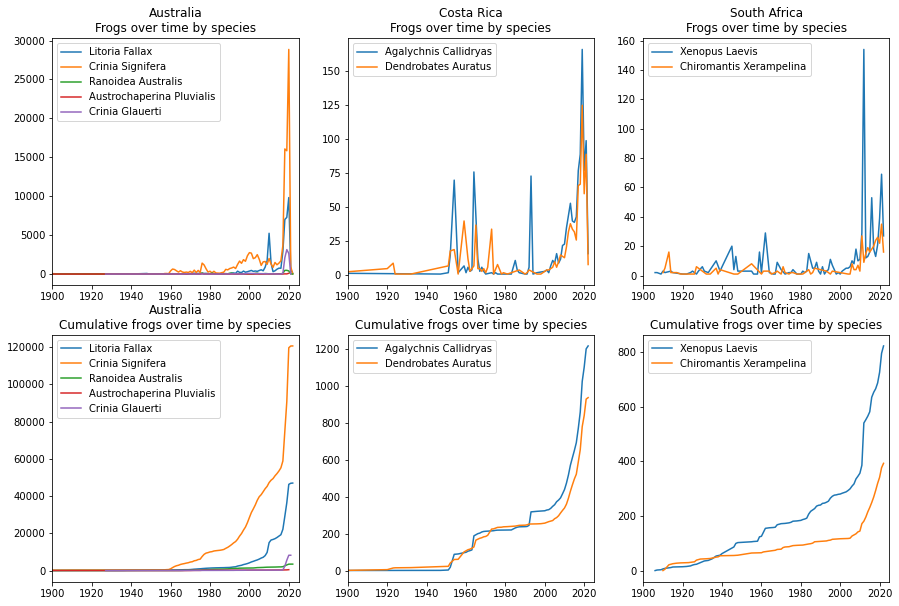

In [16]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

for i, cnt in enumerate(data.country.unique()):
    country_data = data[data.country == cnt]    
    for species in country_data.species.unique():
        plot_data = country_data[lambda x: x.species == species]
        line_data = (
            plot_data
            [['eventDate']]
            .dropna()
            .assign(
                year = lambda x: x.eventDate.dt.year,
                n = 1
            )
            .groupby('year')
            .sum()
            .reset_index()
            .sort_values('year')
            .assign(ncum=lambda x: x.n.cumsum())
        )
        ax[1, i].plot(line_data.year, line_data.ncum, label=species)
        ax[0, i].plot(line_data.year, line_data.n, label=species)
        # ax[0, i].hist(plot_data.eventDate.dt.year, alpha=0.5, label=species, density=True, bins=list(range(1900, 2025, 10)))
    xlim = (1900, 2025)
    # xlim = (country_data.eventDate.dt.year.min(), country_data.eventDate.dt.year.max()) 
    ax[1, i].legend(loc='upper left')
    ax[1, i].set_xlim(xlim)
    ax[1, i].set_title(f"{cnt}\nCumulative frogs over time by species")
    ax[0, i].legend(loc='upper left')
    ax[0, i].set_xlim(xlim)
    ax[0, i].set_title(f"{cnt}\nFrogs over time by species")
